## Start by importing the linear model and check the RMSLE:

In [1571]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm

#Load our two Data Frames
AmesDummiesOrdinalF = pd.read_csv('AmesDummiesOrdinalF.csv', index_col=0)

In [1572]:
OriginalList = list(AmesDummiesOrdinalF.columns).remove('SalePrice')

In [1573]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = AmesDummiesOrdinalF.copy()

In [1574]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [1575]:
#Reindex the AmesDF:
AmesDF.index = range(1166)

In [1576]:
#Run Linear Regression on the Overall (80%) train set, based on earlier K-fold:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Run the linear regression and check RMSLE:
lm.fit(X, Y)
lmscore = lm.score(X, Y)
lmpredict = lm.predict(X)

#Get scores for the Test set
lmtestscore = lm.score(testX, testY)
testpredict = lm.predict(testX)

RMSLE = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredict), 2)))

print("The train R^2 score is: " + str(lmscore))
print("The test R^2 score is: " + str(lmtestscore))
print("The test RMSLE is: " + str(RMSLE))


The train R^2 score is: 0.9067796038750432
The test R^2 score is: 0.8817610014905976
The test RMSLE is: 0.15618786784624622


## Now, import the Random Forest model and check the overall RMSLE:

In [1577]:
#Run Random Forest on the Overall (80%) train set, based on earlier K-fold:


#Import RandomForestRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, 
                        n_estimators=200)

#Run the linear regression and check RMSLE:
randomForest.fit(X, Y)
rfscore = randomForest.score(X, Y)
rfpredict = randomForest.predict(X)

#Get scores for the Test set
rftestscore = randomForest.score(testX, testY)
testpredictrf = randomForest.predict(testX)

RMSLErf = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictrf), 2)))

print("The train R^2 score is: " + str(rfscore))
print("The test R^2 score is: " + str(rftestscore))
print("The test RMSLE is: " + str(RMSLErf))

The train R^2 score is: 0.9999964064459055
The test R^2 score is: 0.906322273435183
The test RMSLE is: 0.13004995570747524


## Now, import the Gradient Boost model and check the overall RMSLE:

In [1578]:
#Run Gradient Boost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
gradientBoost = ensemble.GradientBoostingRegressor()
gradientBoost.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features='log2', max_depth=2, loss='huber')

#Run the linear regression and check RMSLE:
gradientBoost.fit(X, Y)
gbscore = gradientBoost.score(X, Y)
gbpredict = gradientBoost.predict(X)

#Get scores for the Test set
gbtestscore = gradientBoost.score(testX, testY)
testpredictgb = gradientBoost.predict(testX)

RMSLEgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictgb), 2)))

print("The train R^2 score is: " + str(gbscore))
print("The test R^2 score is: " + str(gbtestscore))
print("The test RMSLE is: " + str(RMSLEgb))

The train R^2 score is: 0.973738872004898
The test R^2 score is: 0.9253203564504017
The test RMSLE is: 0.11842452855076531


## Combine (stack) these results to generate a prediction for SalePrice and see if it outperforms the gradient boosting prediction

In [1579]:
stackedpredict = (gradientBoost.predict(testX) + randomForest.predict(testX) + lm.predict(testX))/3
RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
print("The stacked-model RMSLE is: " + str(RMSLEstacked))

The stacked-model RMSLE is: 0.1126762626217371


In [1580]:
'''GradientPct = []
LinearPct = []
BoostPct = []
RMSLE = []
for i in list(range(100)):
    if i > 98:
        continue
    Js = 100-i

    for j in list(range(Js)):
        if i + j > 99:
            continue
            
        Ks = 101-i-j

        for k in list(range(Ks)):
            if i + j + k != 100:
                continue
            GradientPct.append(i)
            LinearPct.append(k)
            BoostPct.append(j)
            
            stackedpredict = (i*gradientBoost.predict(testX) + j*randomForest.predict(testX) + k*lm.predict(testX))/100
            RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
            RMSLE.append(RMSLEstacked)
            #print("gradient %: " + str(i) + ", randomforest%: " + str(j) + ", linear%: " + str(k) + ": RMSLE= " + str(RMSLEstacked))'''
    

'GradientPct = []\nLinearPct = []\nBoostPct = []\nRMSLE = []\nfor i in list(range(100)):\n    if i > 98:\n        continue\n    Js = 100-i\n\n    for j in list(range(Js)):\n        if i + j > 99:\n            continue\n            \n        Ks = 101-i-j\n\n        for k in list(range(Ks)):\n            if i + j + k != 100:\n                continue\n            GradientPct.append(i)\n            LinearPct.append(k)\n            BoostPct.append(j)\n            \n            stackedpredict = (i*gradientBoost.predict(testX) + j*randomForest.predict(testX) + k*lm.predict(testX))/100\n            RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))\n            RMSLE.append(RMSLEstacked)\n            #print("gradient %: " + str(i) + ", randomforest%: " + str(j) + ", linear%: " + str(k) + ": RMSLE= " + str(RMSLEstacked))'

In [1581]:
'''Gradient = pd.Series(GradientPct)
Linear = pd.Series(LinearPct)
RandomForest = pd.Series(BoostPct)
RMSLESeries = pd.Series(RMSLE)

StackGridSearchDF = pd.DataFrame({'LinearPct':Linear, 'RForestPct':RandomForest, 'GBoostPct':Gradient, 'RMSLE':RMSLESeries})'''

"Gradient = pd.Series(GradientPct)\nLinear = pd.Series(LinearPct)\nRandomForest = pd.Series(BoostPct)\nRMSLESeries = pd.Series(RMSLE)\n\nStackGridSearchDF = pd.DataFrame({'LinearPct':Linear, 'RForestPct':RandomForest, 'GBoostPct':Gradient, 'RMSLE':RMSLESeries})"

In [1582]:
#StackGridSearchDF.sort_values(by='RMSLE', axis=0, ascending=False).head()

In [1583]:
#StackGridSearchDF.sort_values(by='RMSLE', axis=0).head()

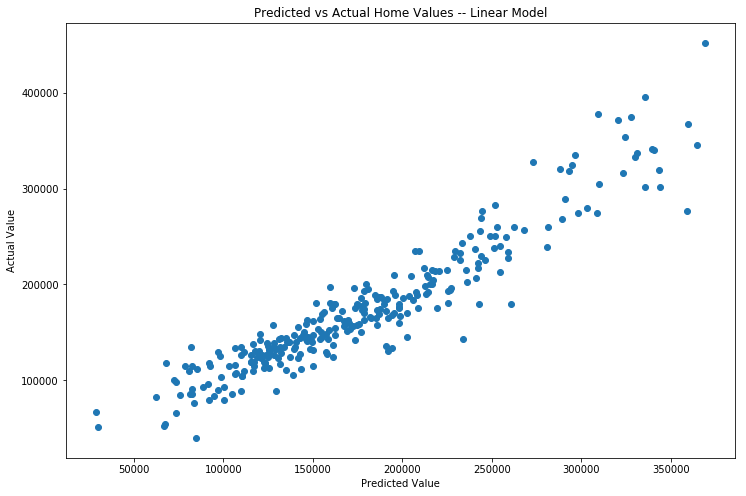

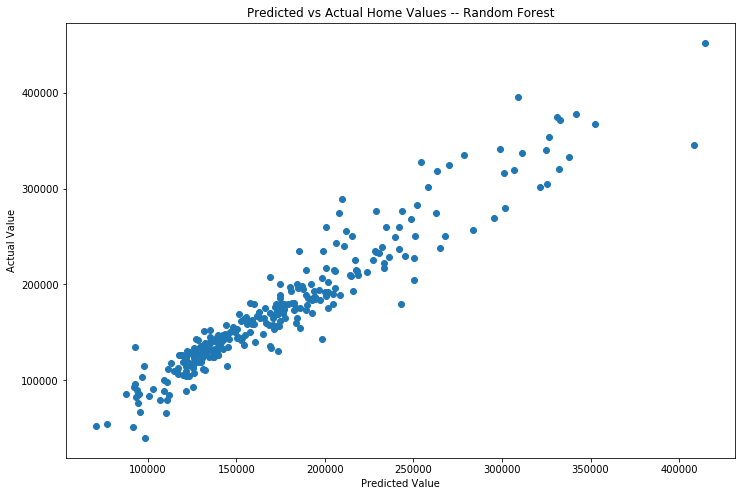

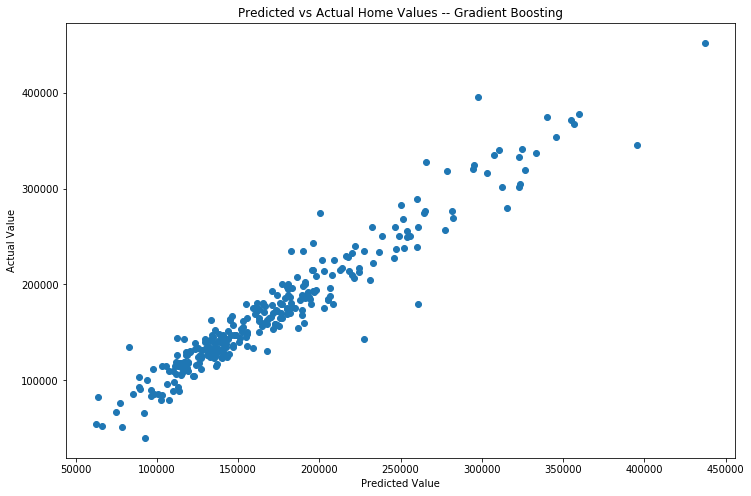

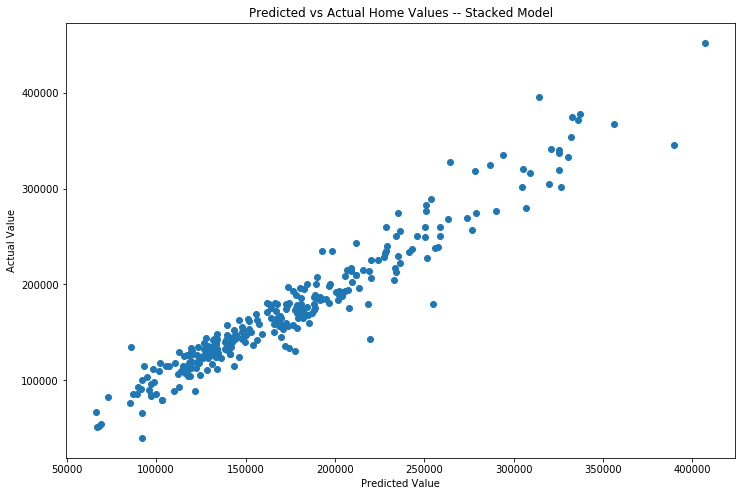

In [1584]:
import matplotlib.pyplot as plt

for tup in [('Linear Model', testpredict), ('Random Forest', testpredictrf), ('Gradient Boosting', testpredictgb), ('Stacked Model', stackedpredict)]:

    plt.figure(figsize=(12,8))
    plt.scatter(tup[1], testY)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('Predicted vs Actual Home Values -- ' + tup[0])   
    plt.show()